In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import SVHN
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, nll_masked_batch_loss_same_size_masks
from pathlib import Path
import inpainting.visualizations.samples as vis
import pickle

In [4]:
from inpainting.datasets.celeba import train_val_datasets as celeba_train_val_ds
from inpainting.datasets.svhn import train_val_datasets as svhn_train_val_ds

from inpainting.visualizations.digits import rgb_with_mask 
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted
from inpainting.inpainters.rgb import RGBInpainter

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
# !ps aux | grep mprzewie 

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

0
Wed Feb  5 07:41:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   27C    P8     7W / 250W |    641MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   34C    P8    10W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [9]:
experiment_path = Path("../results/svhn/a_amplitude_0.5_two_masks")
experiment_path.mkdir(exist_ok=True, parents=True)

Using downloaded and verified file: /home/mprzewiezlikowski/uj/.data/train_32x32.mat
Using downloaded and verified file: /home/mprzewiezlikowski/uj/.data/test_32x32.mat


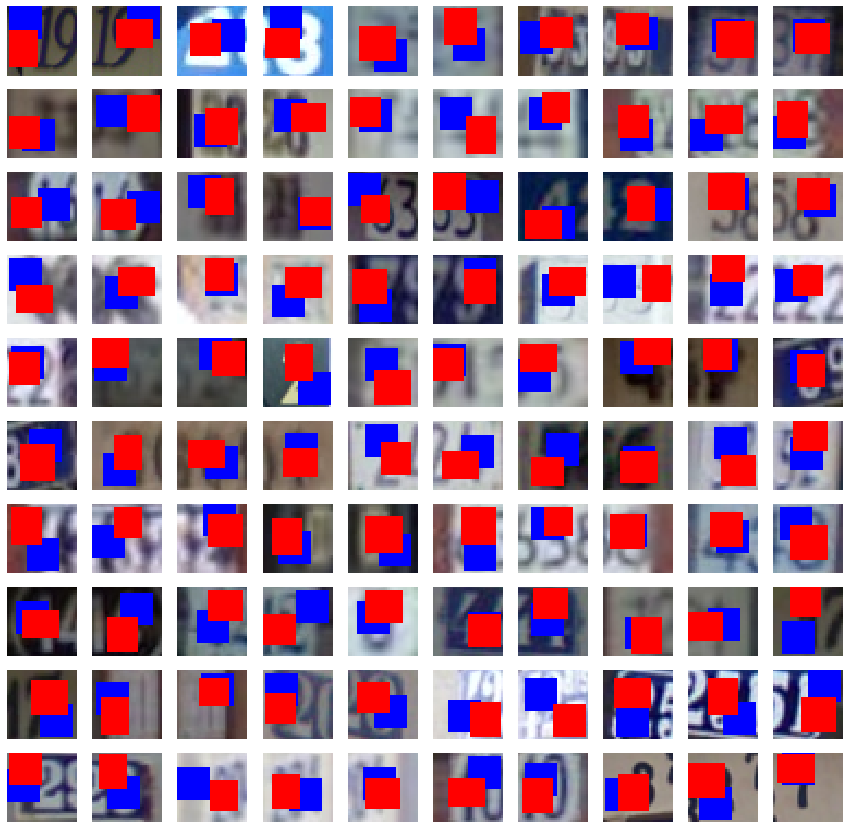

(73257, 26032)

In [10]:
ds_train, ds_val = svhn_train_val_ds(Path.home() / "uj/.data/")

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
#     print(x.shape)
    ax = axes[i // 10, i%10]
#     ax.set_title(f"{y}")
    rgb_with_mask(x.numpy(), j.numpy(), ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

len(ds_train), len(ds_val)

In [11]:
batch_size=64
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [12]:
m_std = lambda x, j, p, m, a, d: m.std(dim=0).mean()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
history = []
inpainter = RGBInpainter(n_mixes=1, a_amplitude=0.5)
opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)
n_epochs = 50

history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn = nll_masked_batch_loss, 
    n_epochs=n_epochs,
    losses_to_log=None,
    device=device,
    history_start=history,
#     tqdm_loader=True
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 50/50 [2:56:49<00:00, 212.19s/it]  


In [14]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [15]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

torch.save(inpainter.state_dict, experiment_path / "inpainter.state")

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RGBInpainter. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It

In [16]:
[h["losses"] for h in history];

In [17]:
history[-1]["losses"]["objective"]

{'train': -739.1168, 'val': -1037.14}

In [18]:
history_tmp = history
history = history

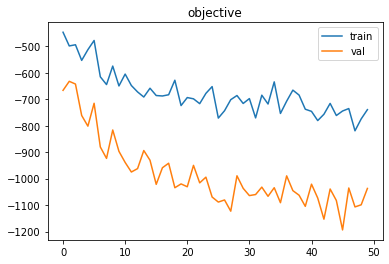

In [19]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

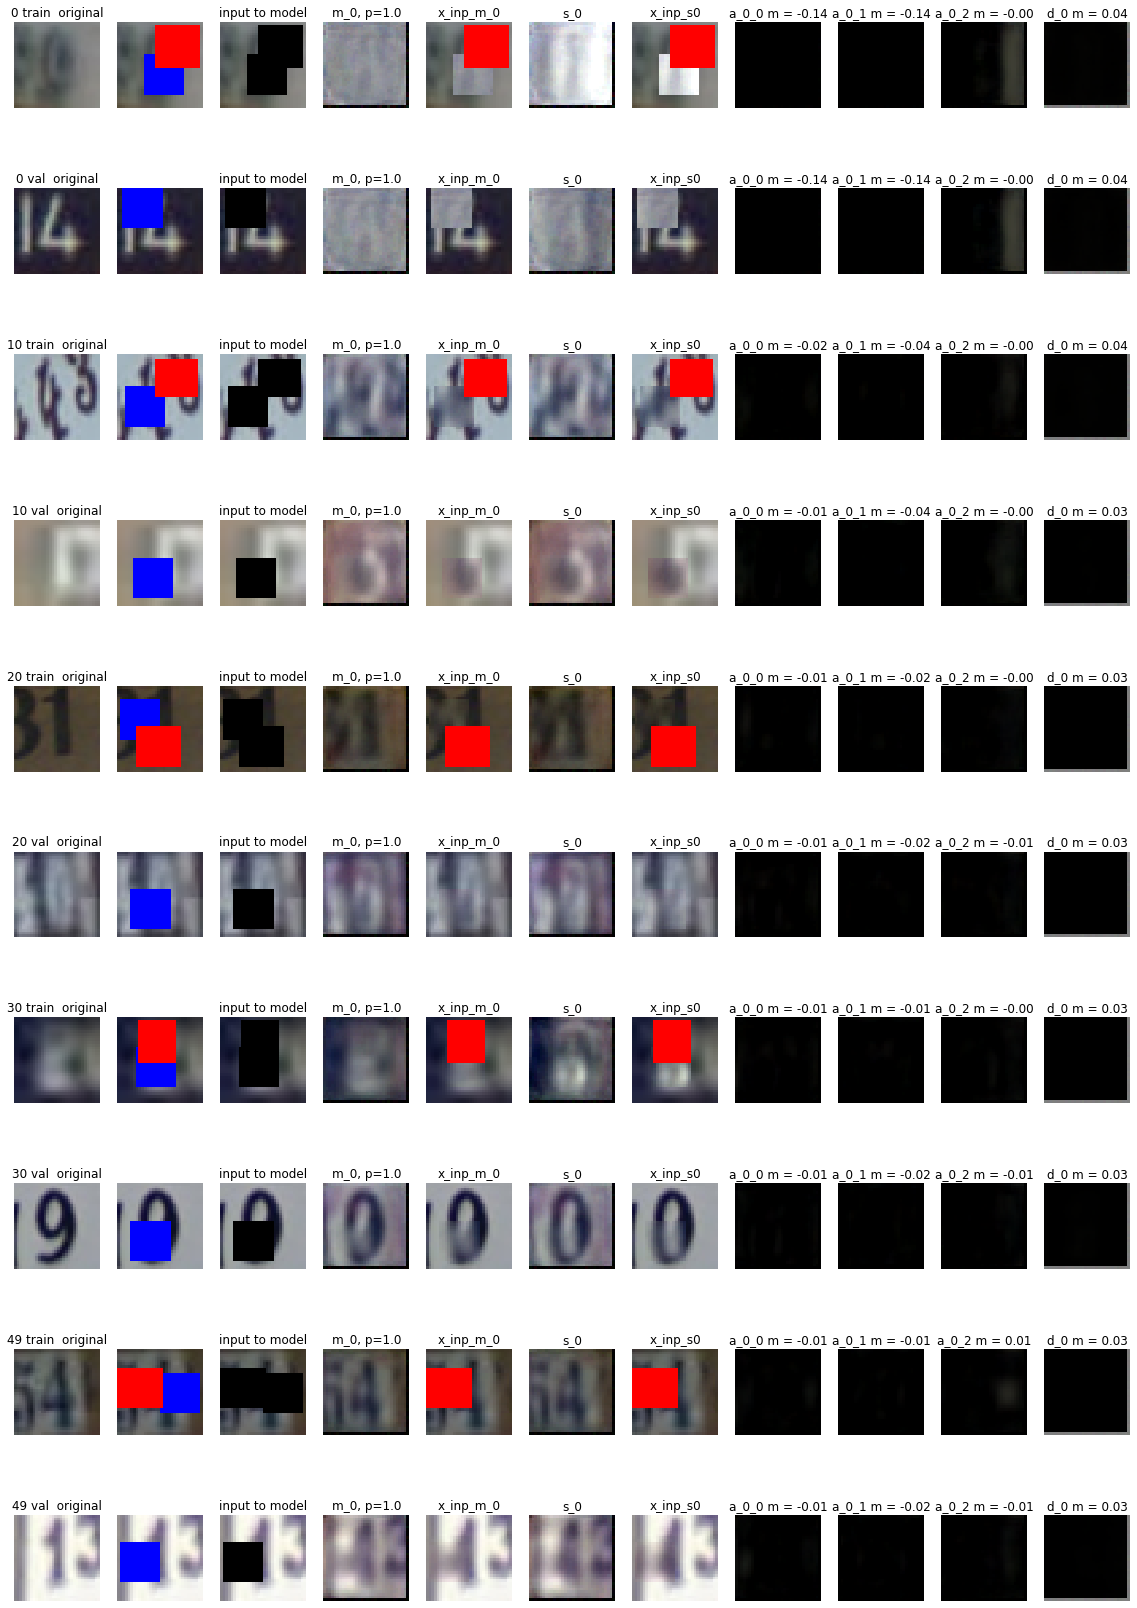

In [20]:
skip = 10

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=rgb_with_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

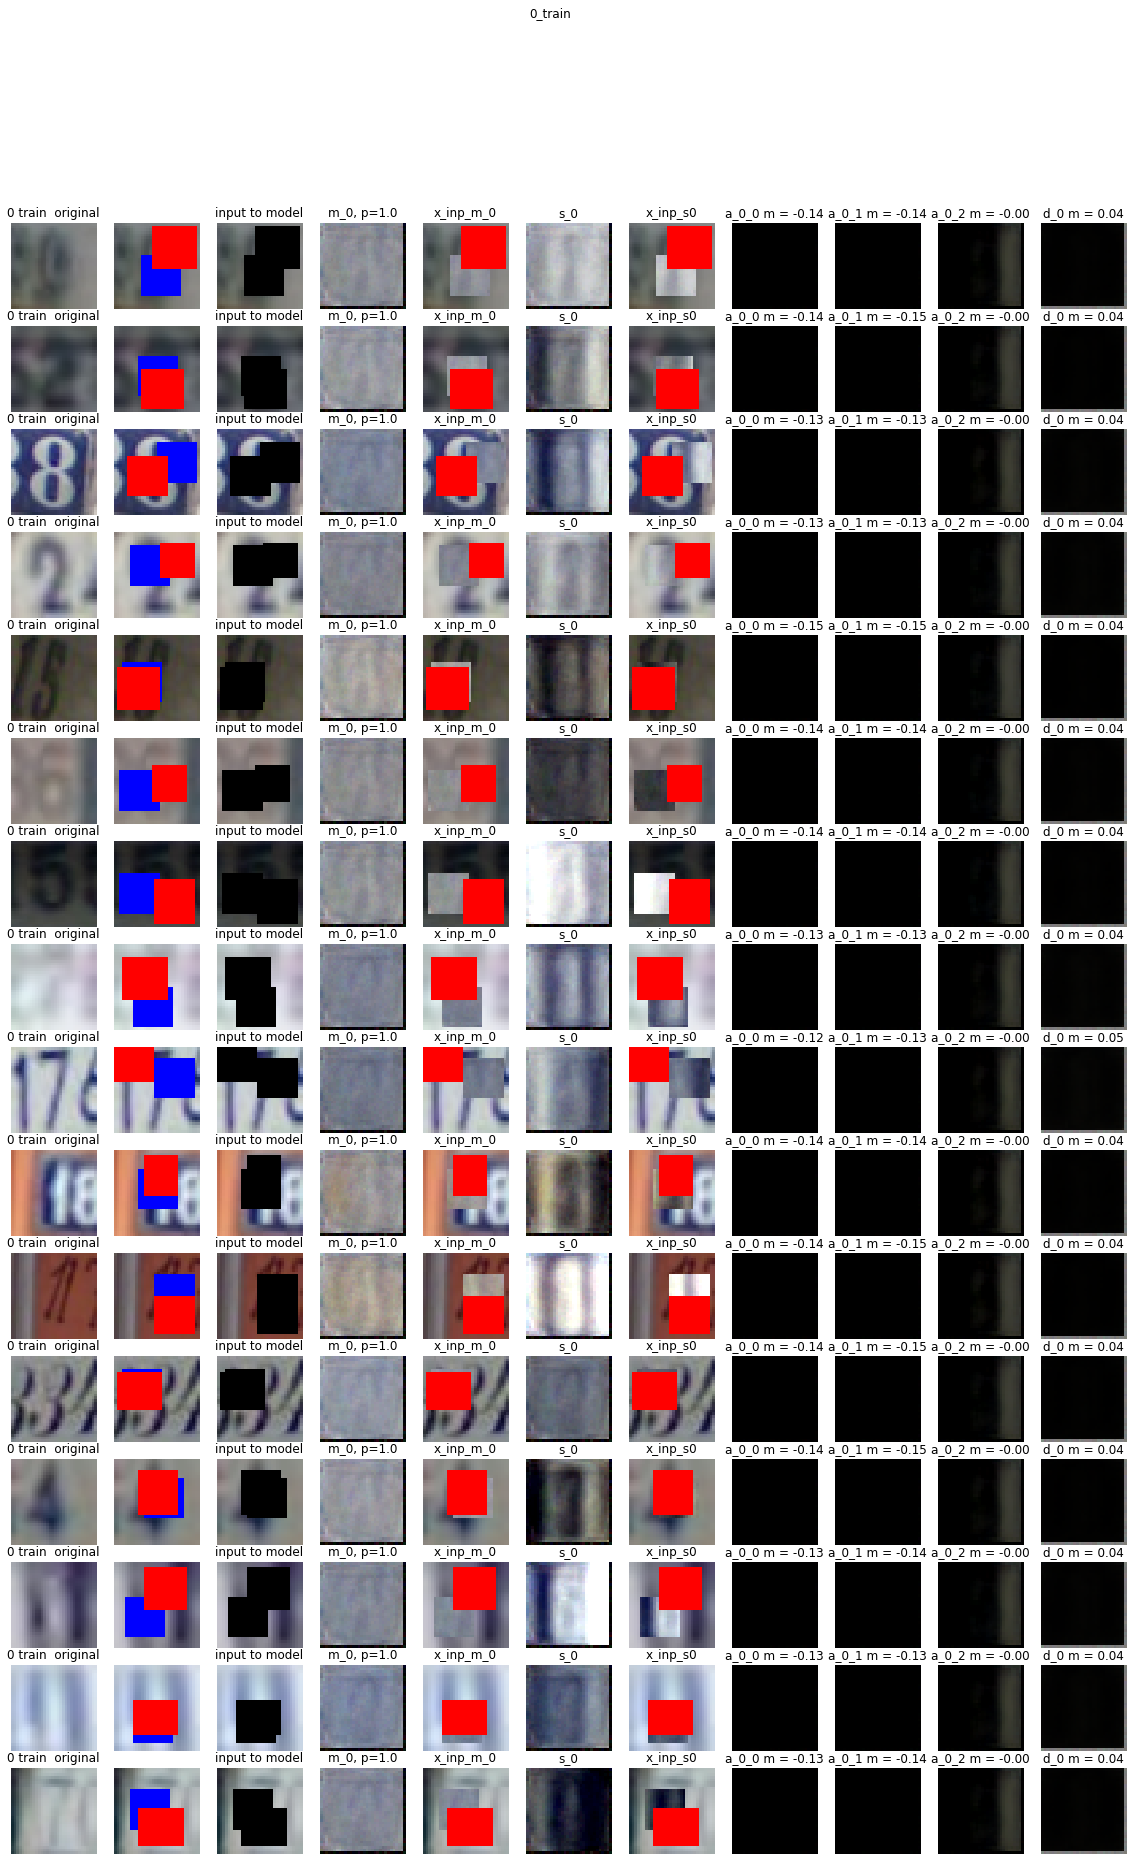

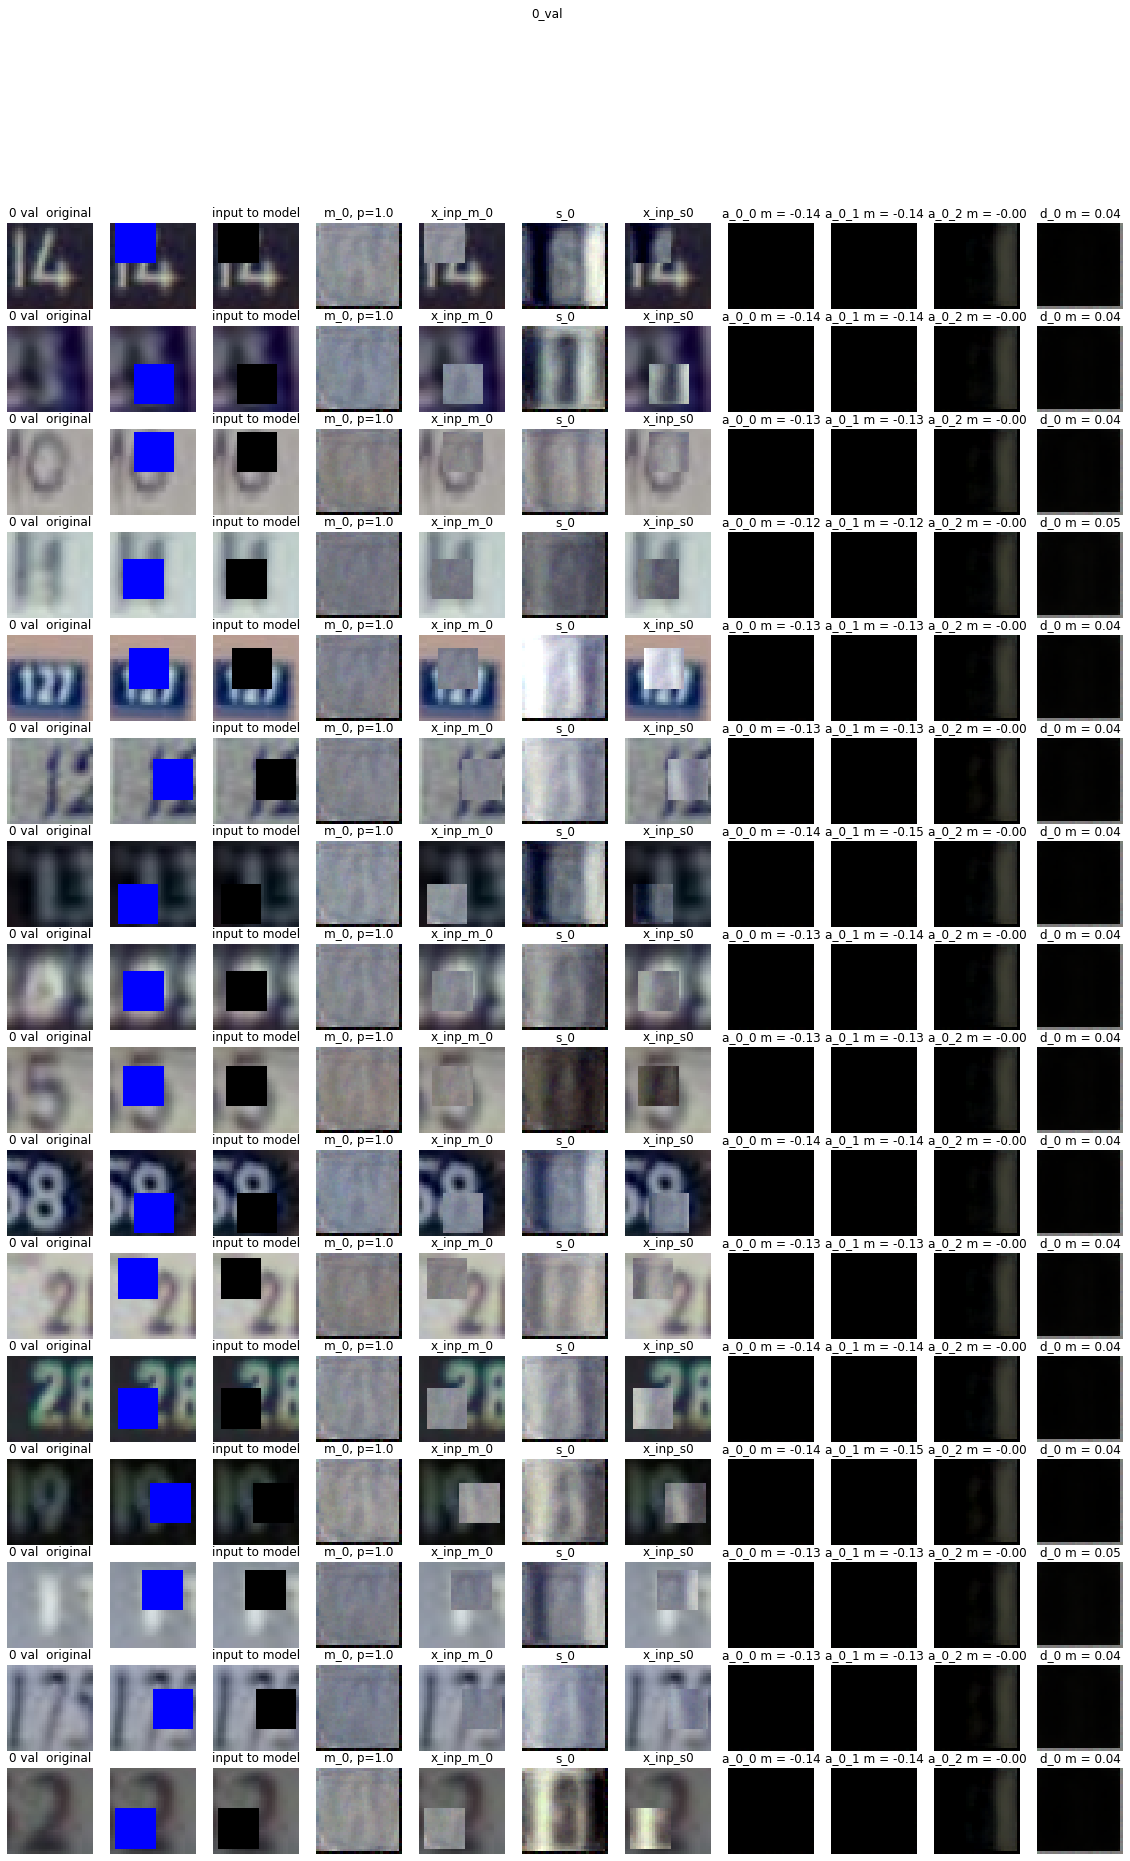

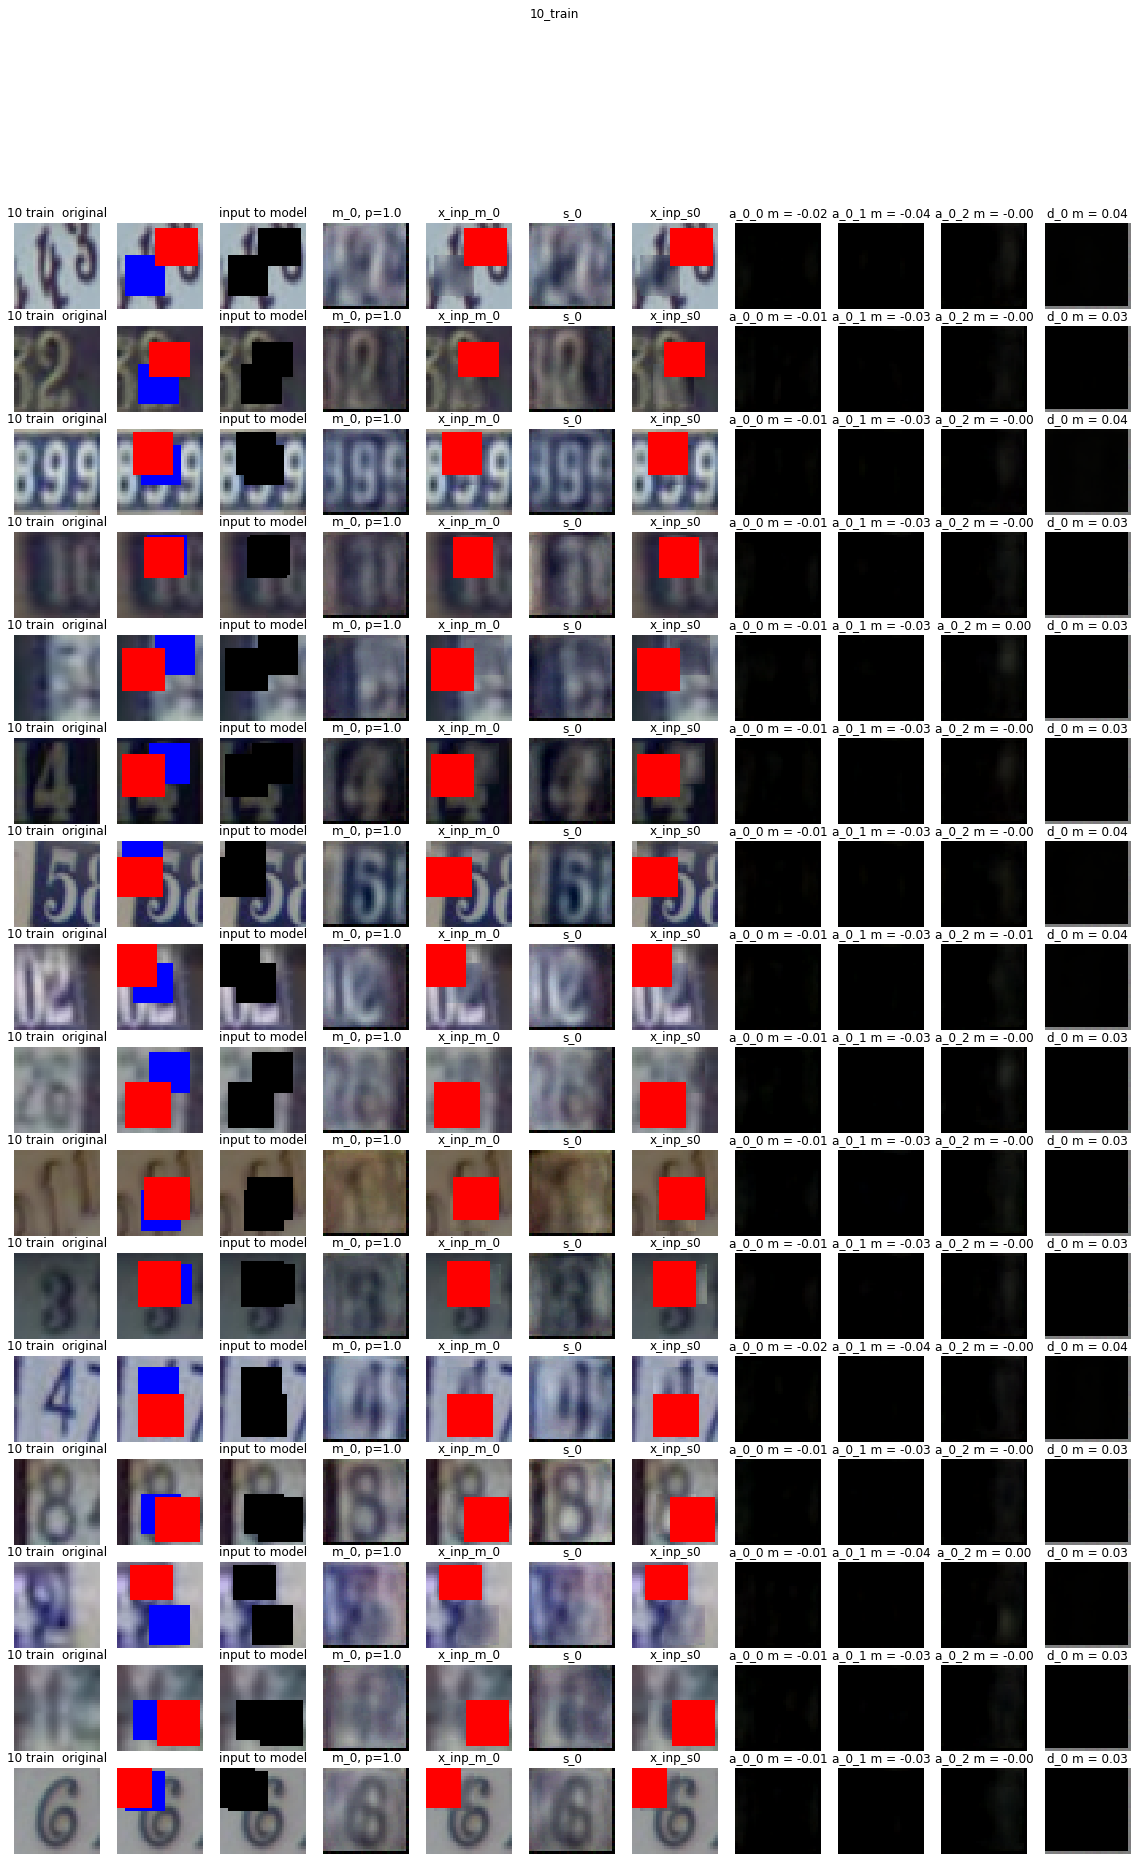

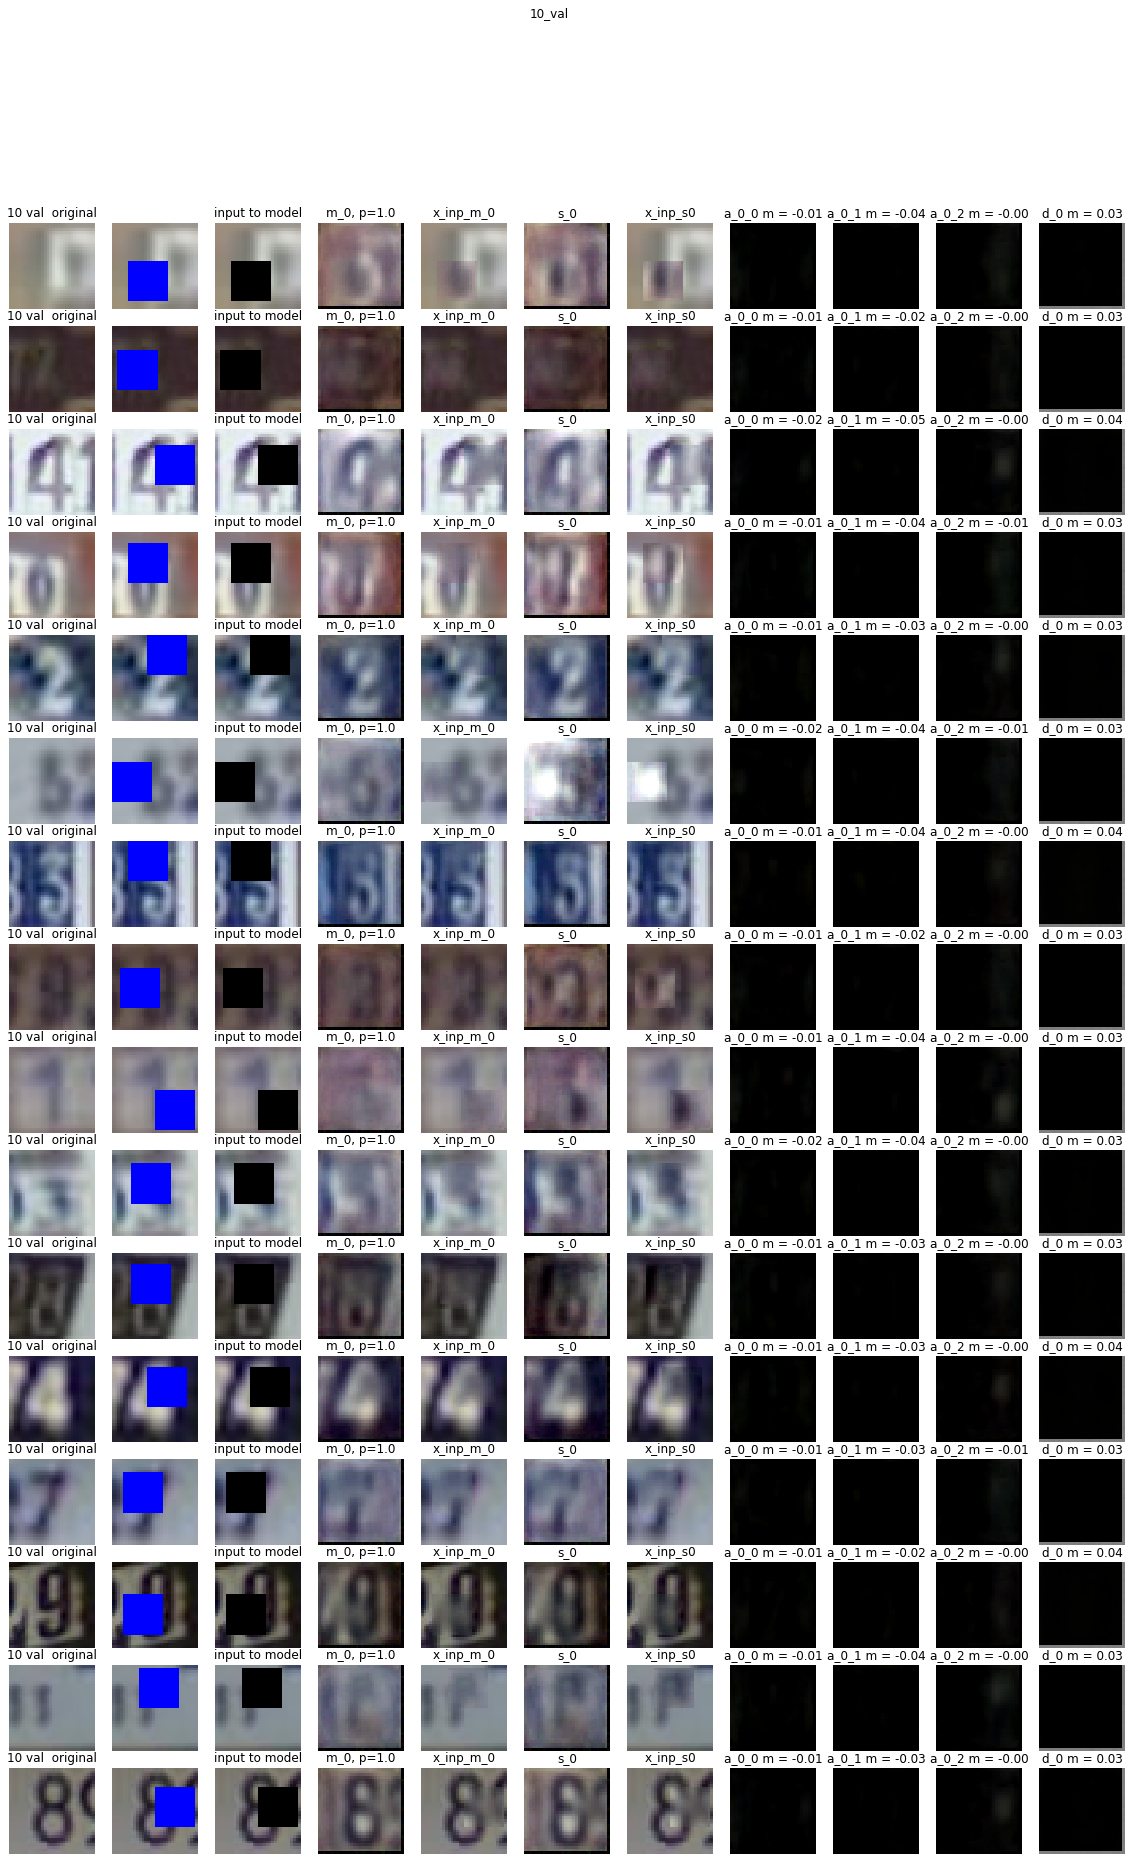

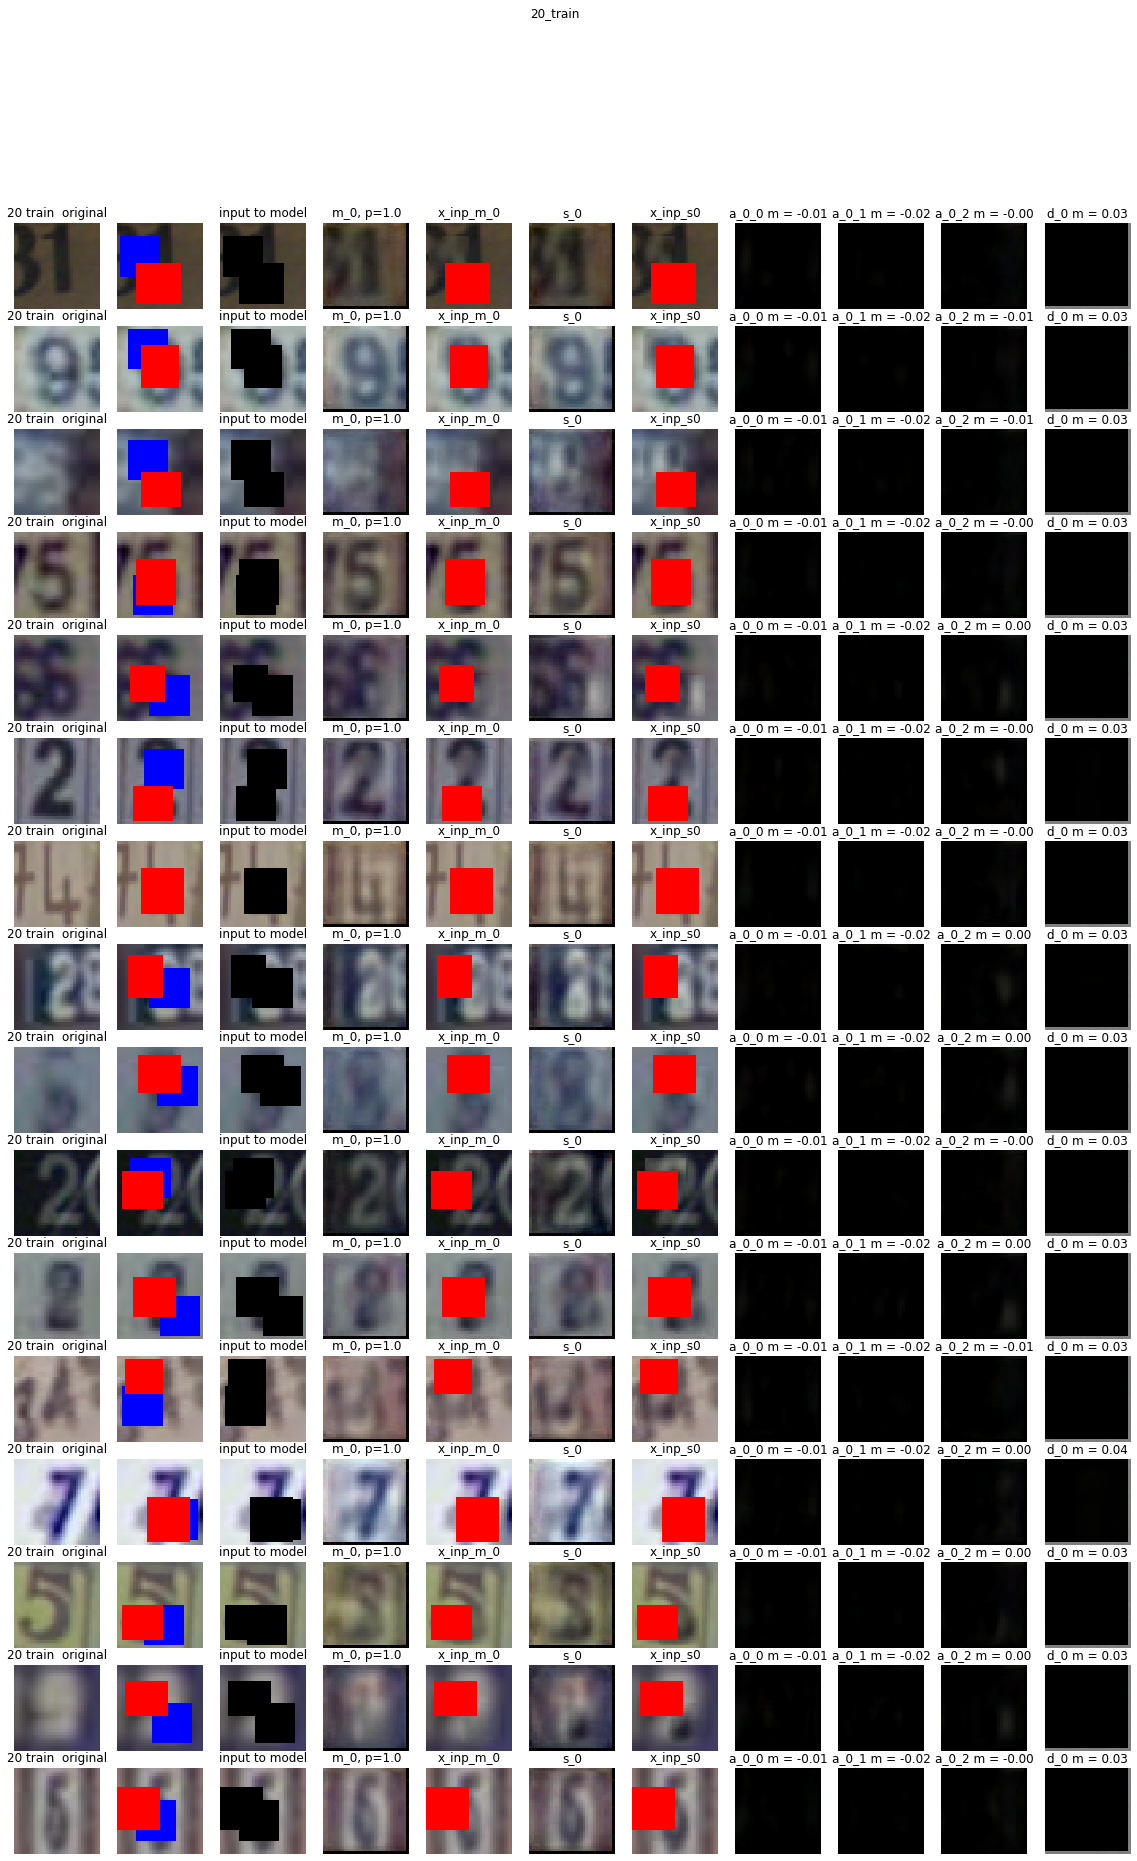

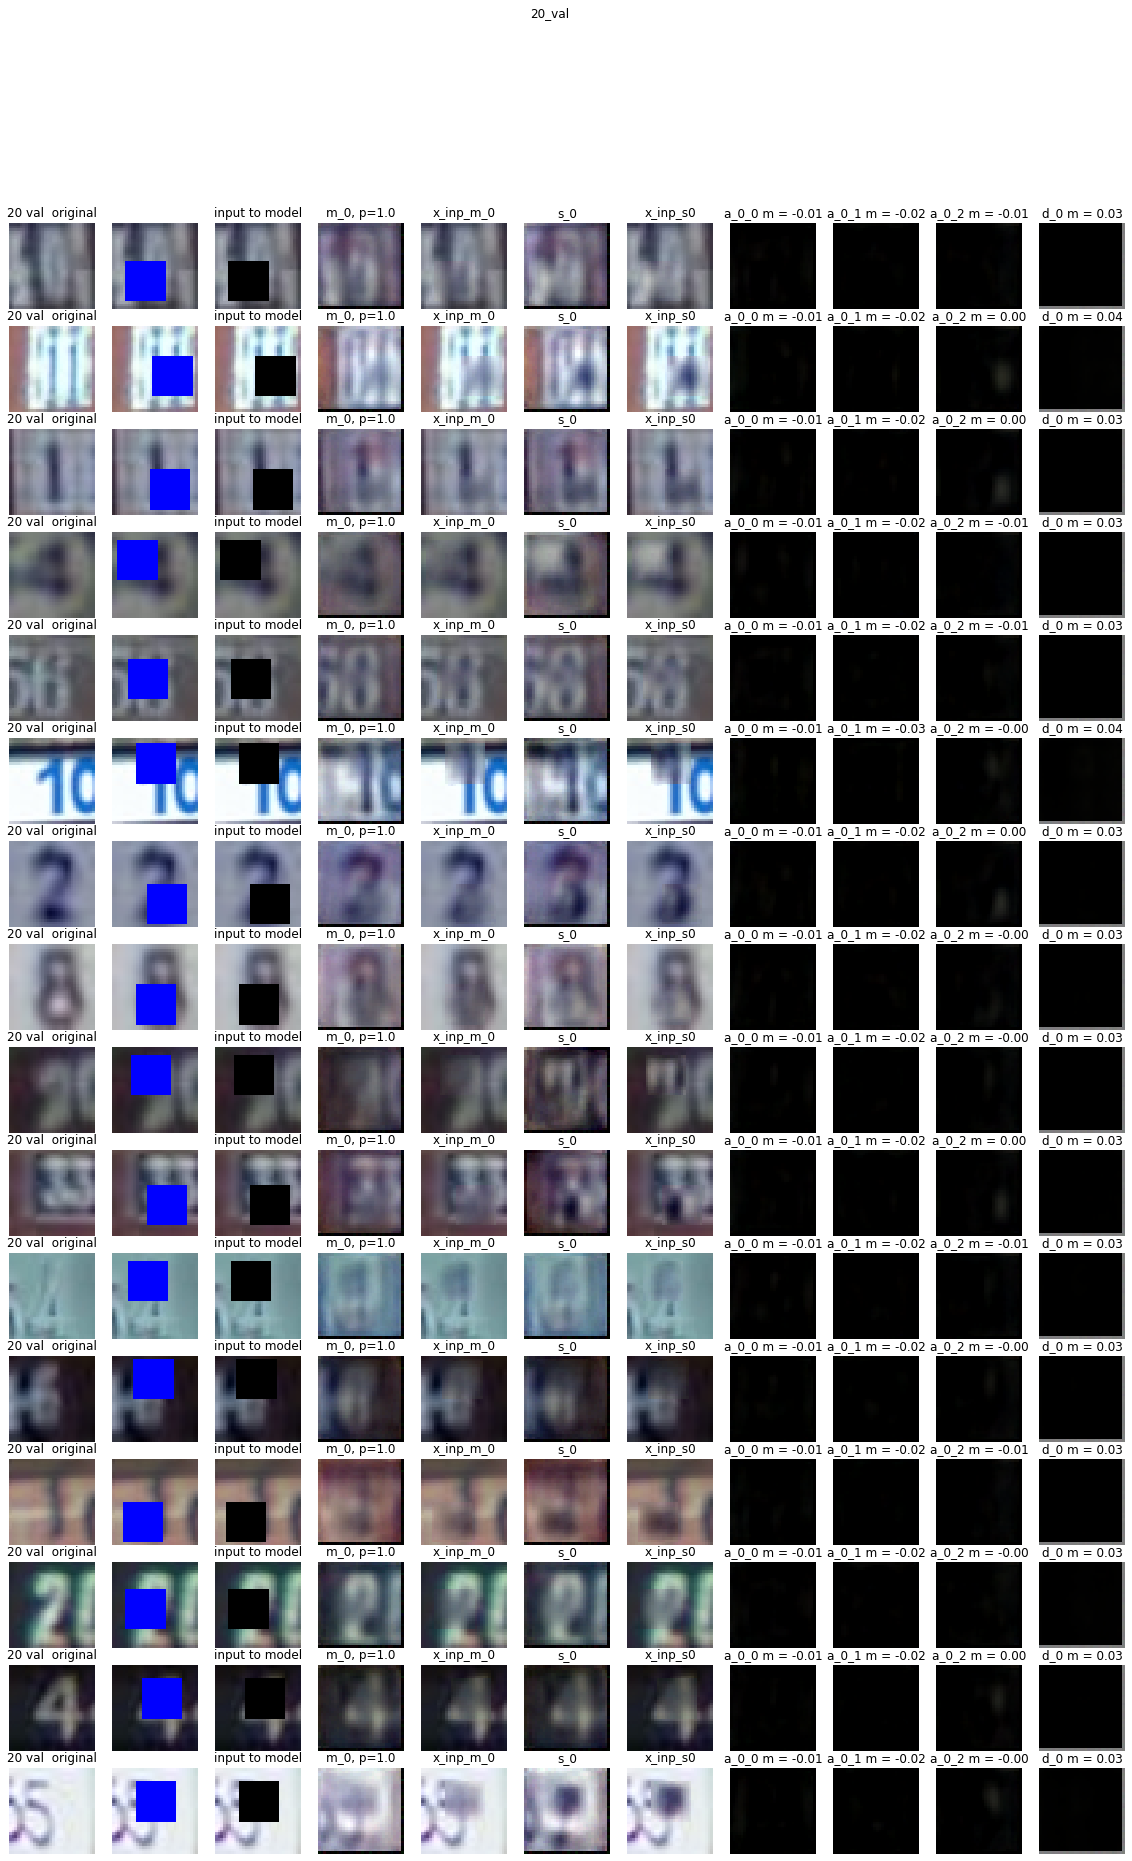

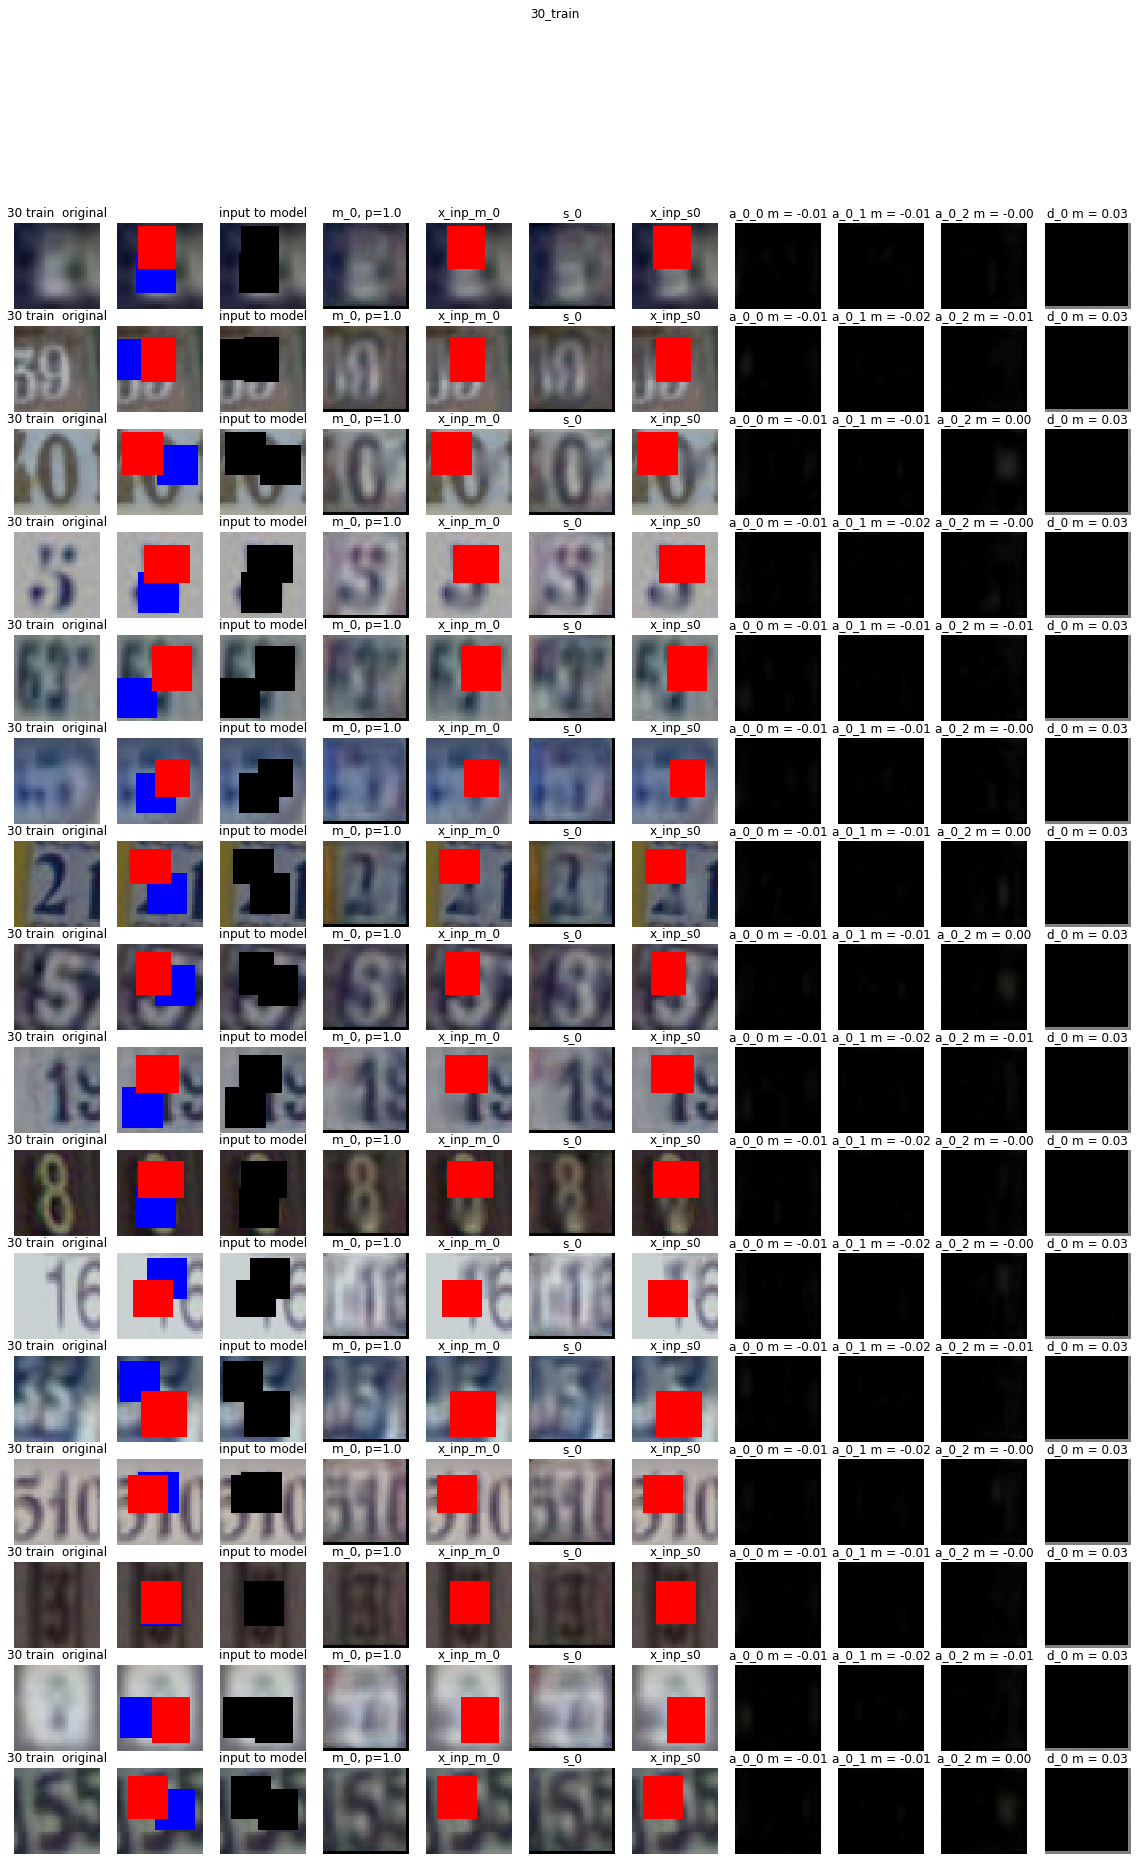

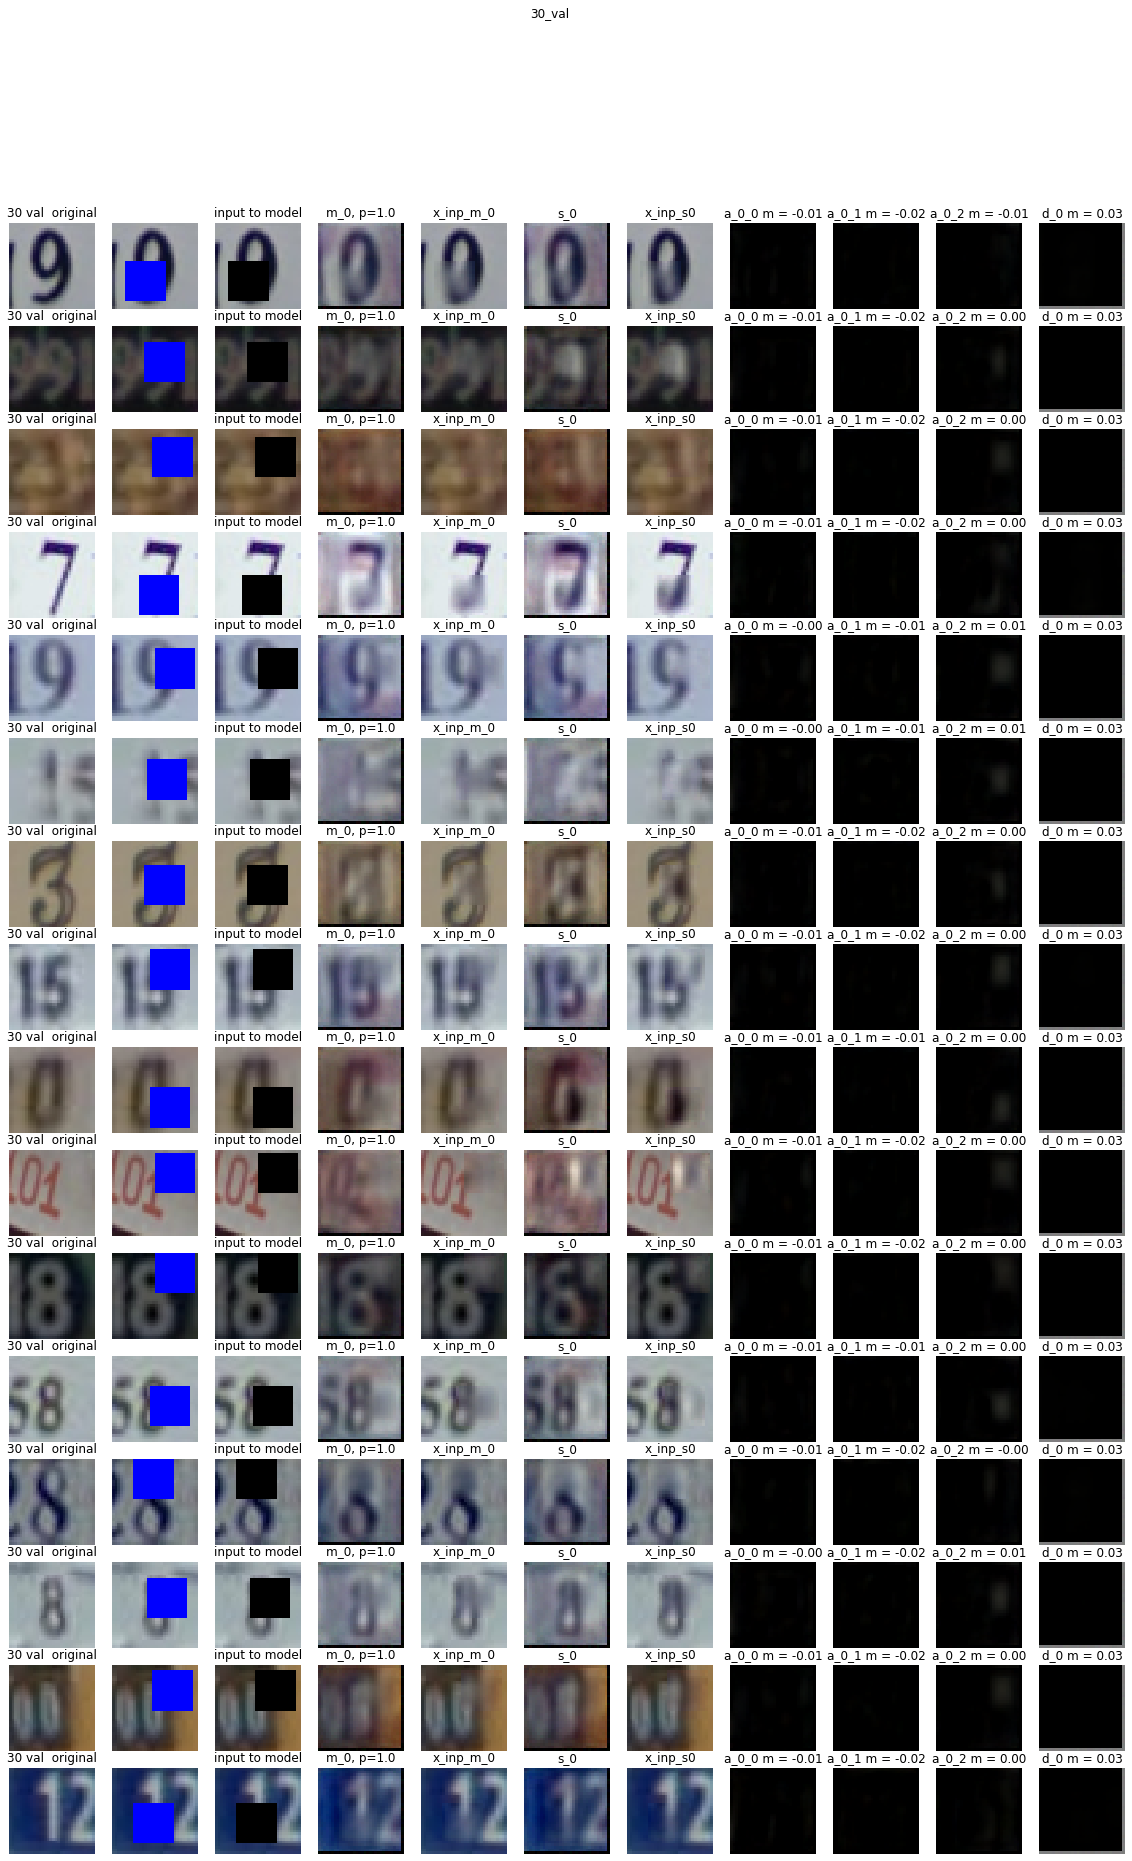

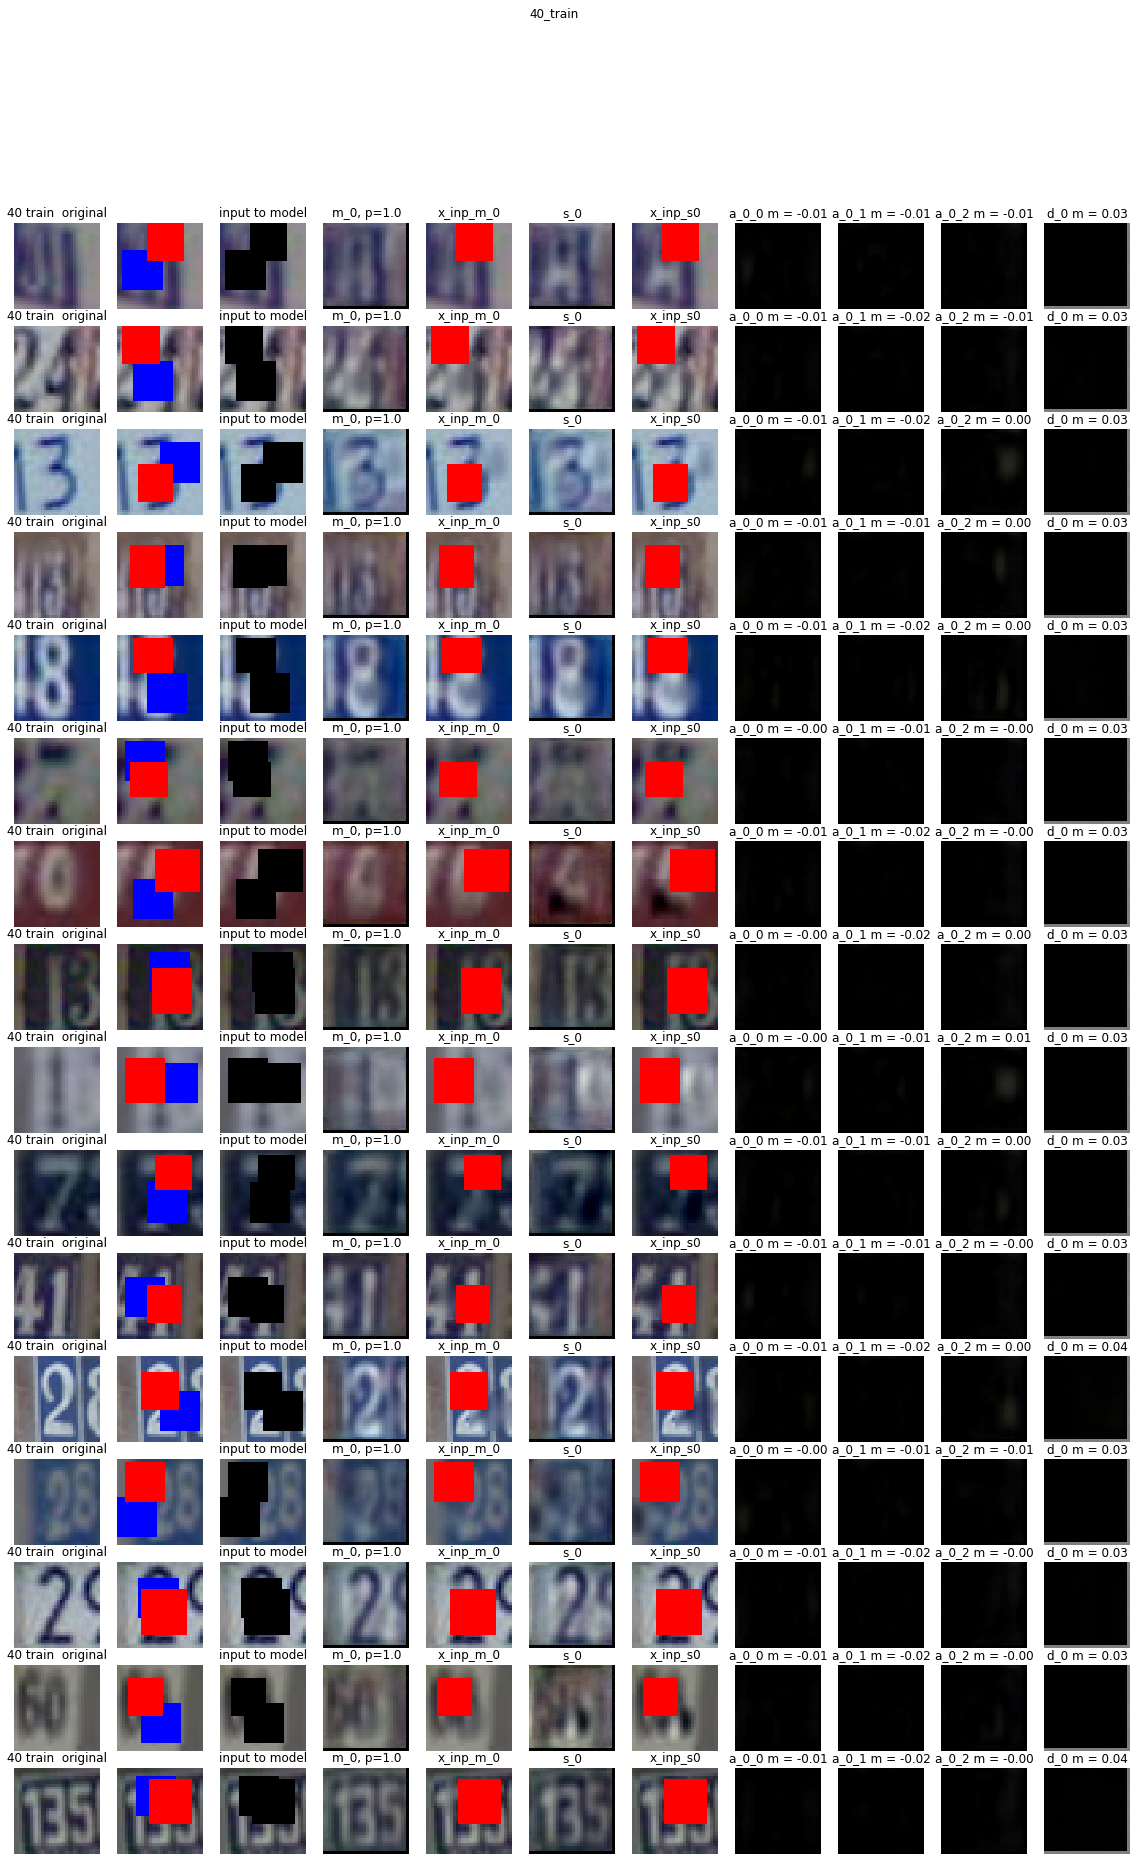

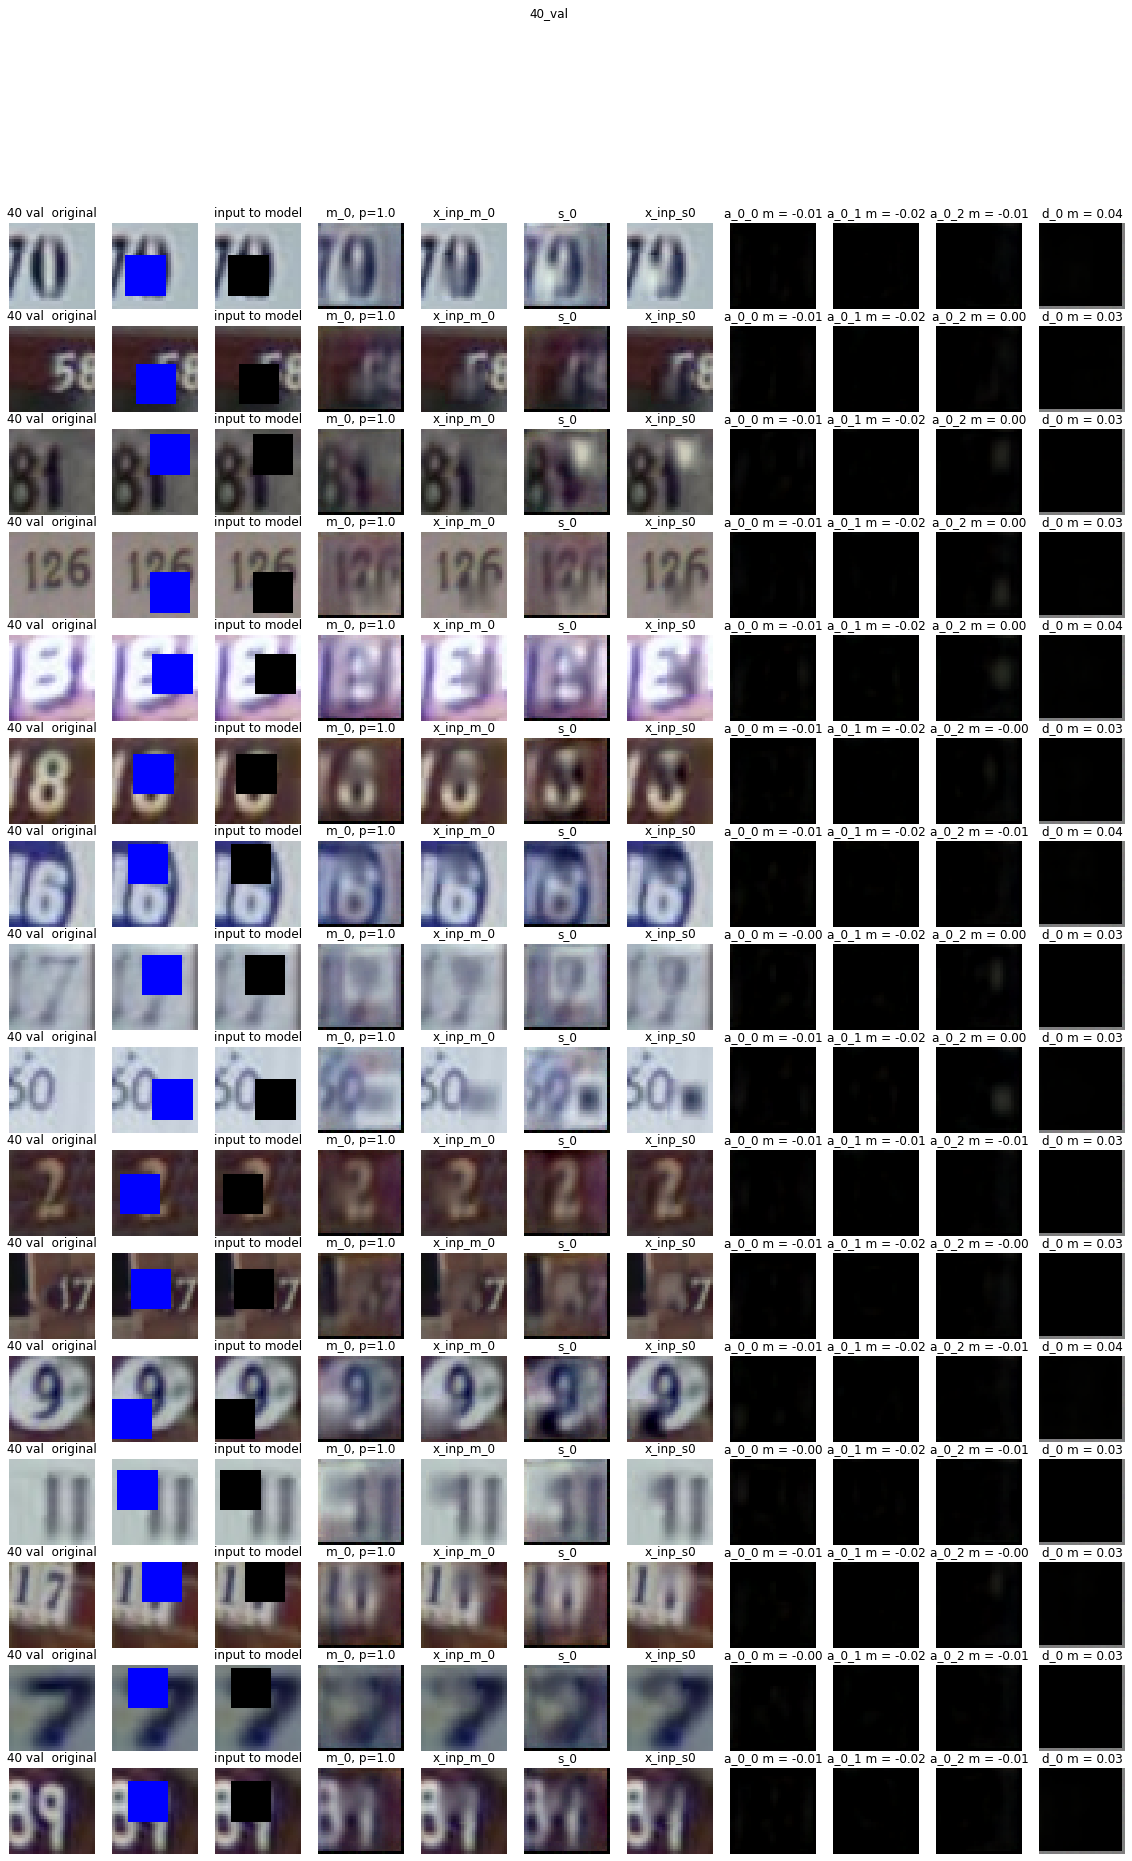

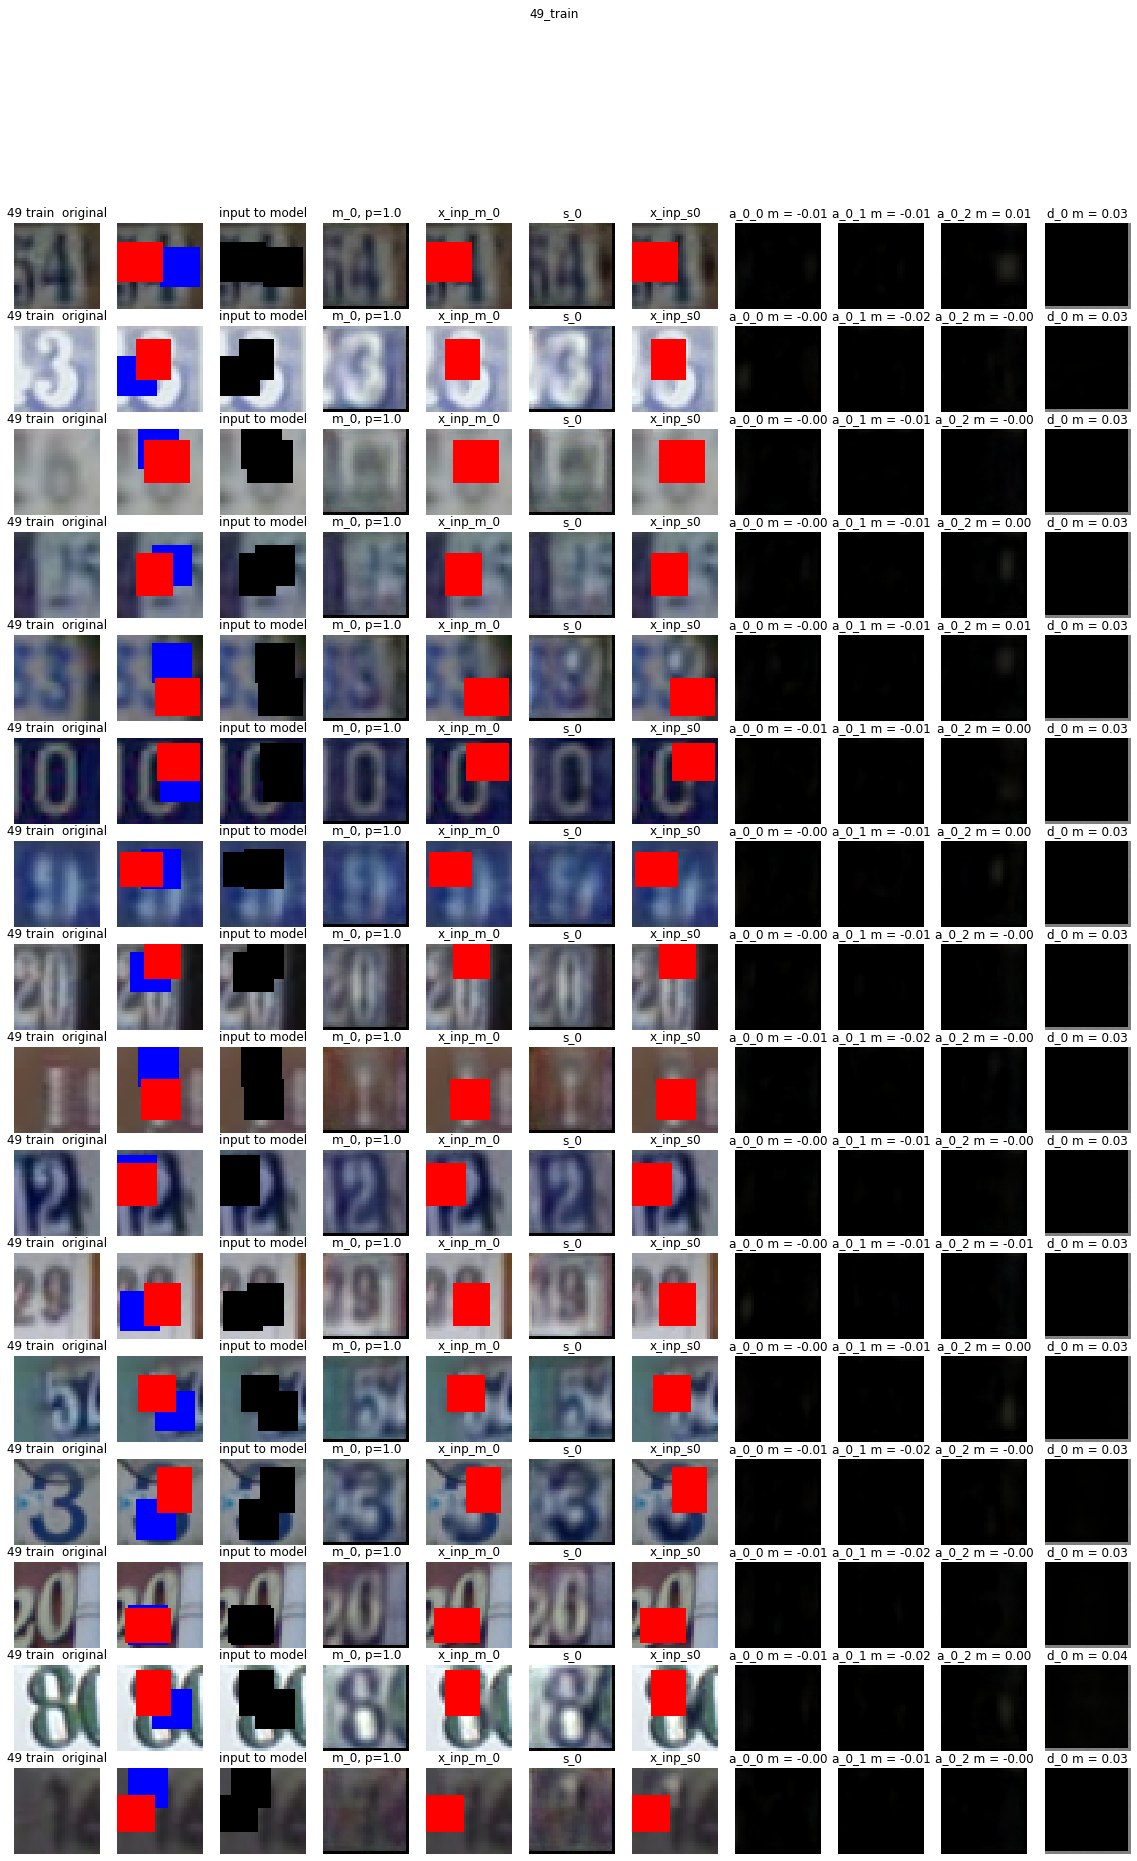

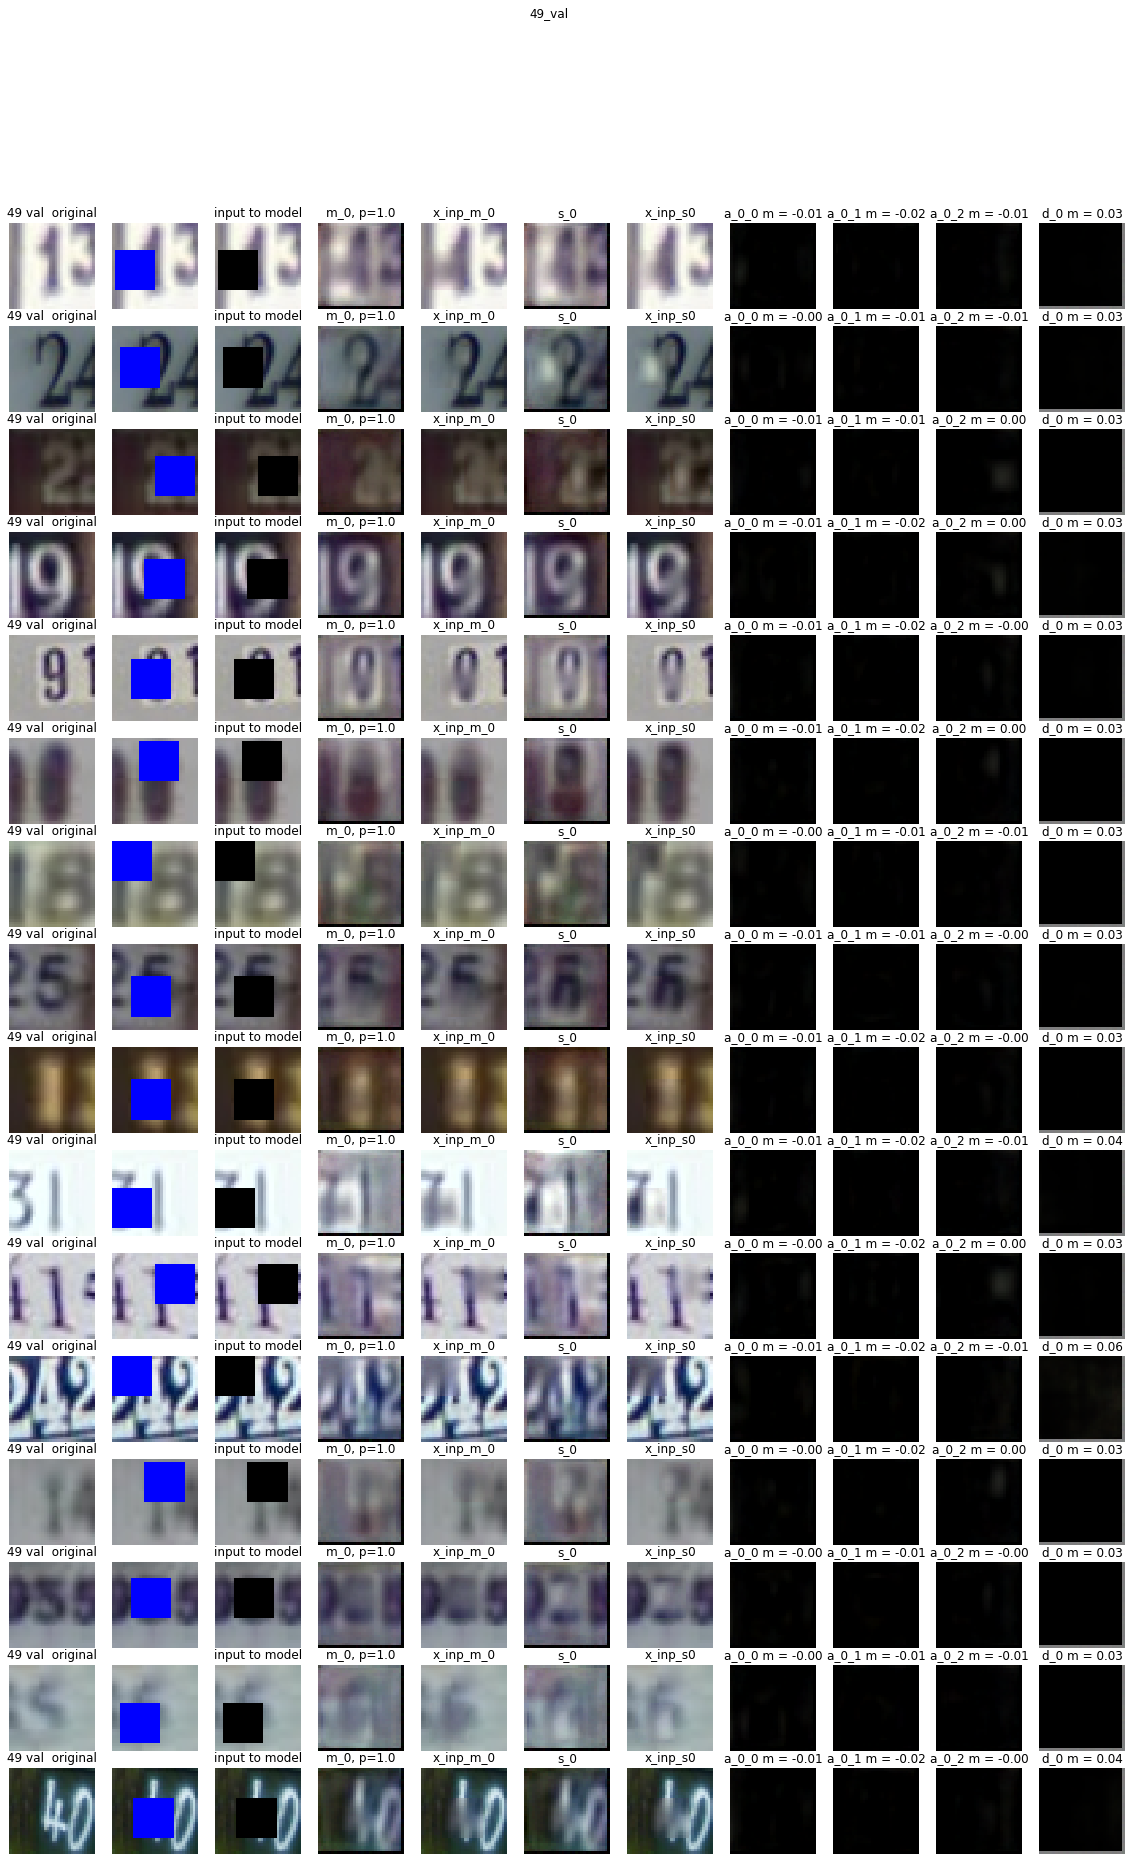

In [21]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 10
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=rgb_with_mask
            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#         plt.show()
            

# epochs_fig = plt.gcf()
# epochs_fig.savefig(experiment_path / "epochs_renders.png")

In [22]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

In [23]:
hist_last_epoch = history[-1]

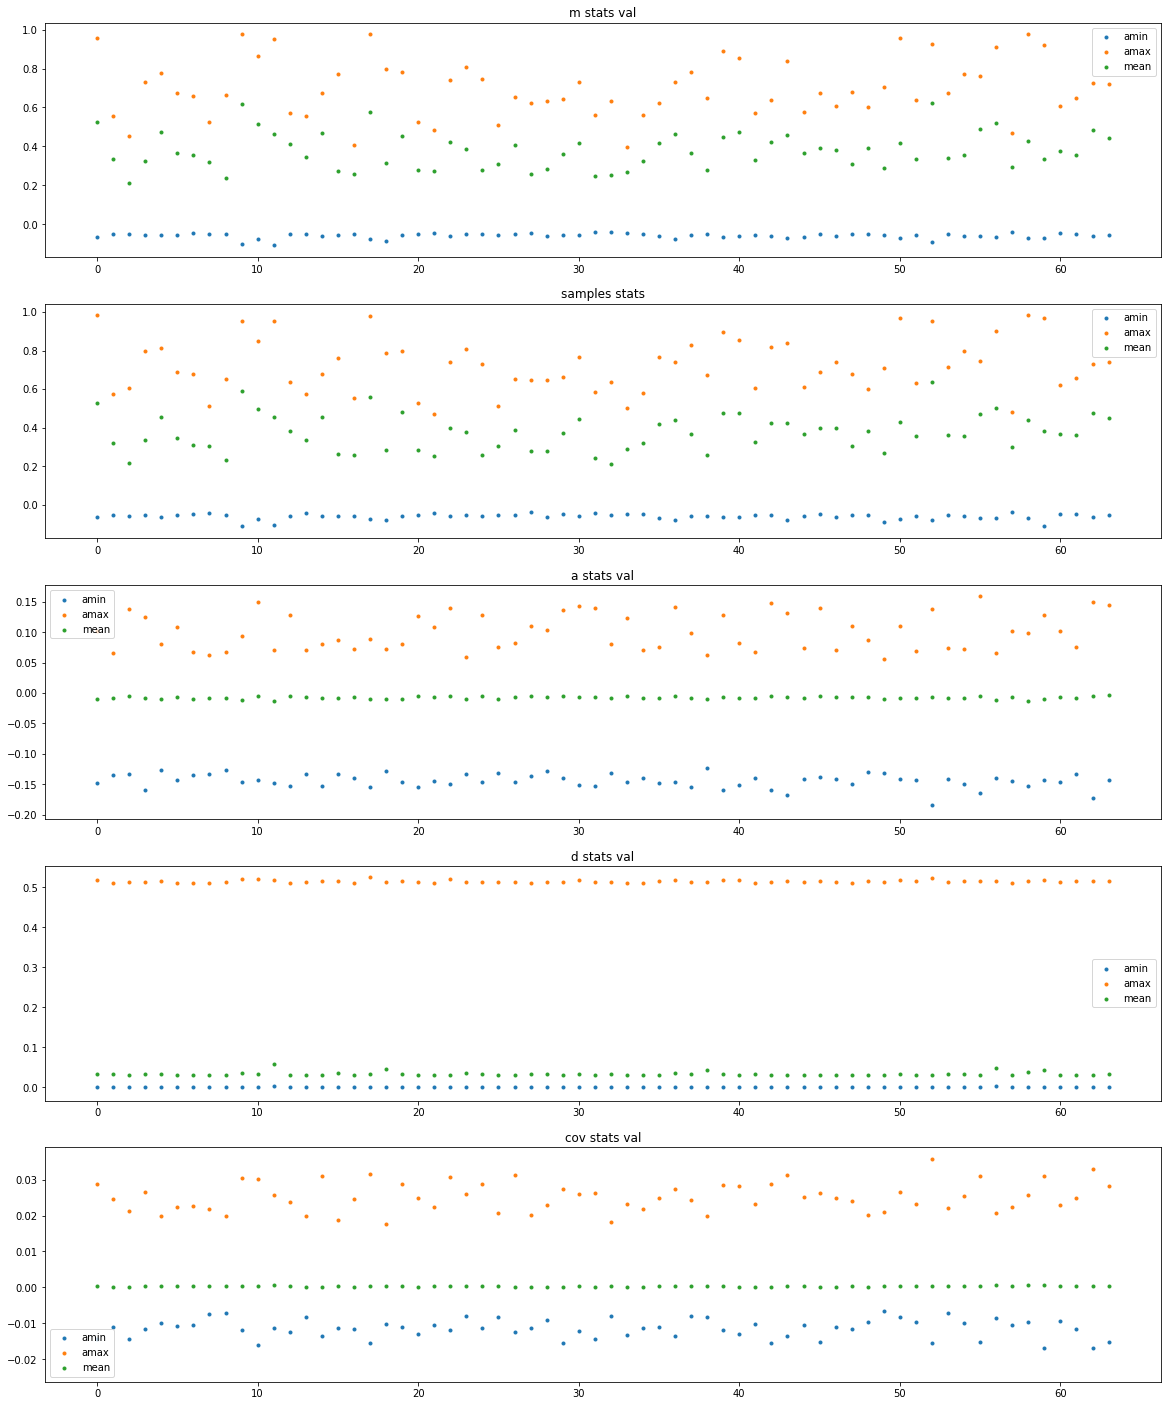

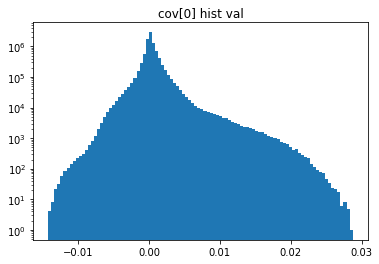

In [ ]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
#     for i in range(3):
#         plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
#         plt.show()
    
    
    
    